## **Dependencies**

In [35]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC 
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

from imblearn.combine import SMOTEENN, SMOTETomek # because our data is unbalanced

random_state = 0
np.random.seed(random_state)


## **Data Processing**

In [2]:
dat_nurse = pd.read_csv('./data/prepared_1061.csv')
# dat_nurse.head()

In [3]:
dat_nurse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   HADM_ID                   1061 non-null   int64  
 1   group                     1061 non-null   int64  
 2   ID                        1061 non-null   int64  
 3   outcome                   1060 non-null   float64
 4   age                       1061 non-null   int64  
 5   gendera                   1061 non-null   int64  
 6   BMI                       865 non-null    float64
 7   hypertensive              1061 non-null   int64  
 8   atrialfibrillation        1061 non-null   int64  
 9   CHD with no MI            1061 non-null   int64  
 10  diabetes                  1061 non-null   int64  
 11  deficiencyanemias         1061 non-null   int64  
 12  depression                1061 non-null   int64  
 13  Hyperlipemia              1061 non-null   int64  
 14  Renal fa

(array([921.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 139.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

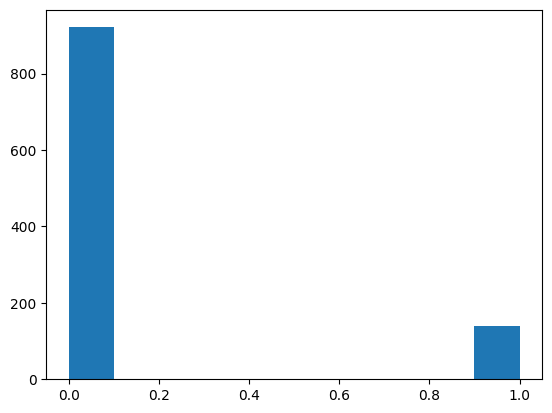

In [4]:
plt.hist(dat_nurse['outcome'])

In [5]:
# drop na (outcome na)
dat_nurse = dat_nurse[dat_nurse['outcome'].notnull()]
# train-test-split
train_dat, test_dat = train_test_split(dat_nurse, test_size = 0.15,  stratify=dat_nurse['outcome'], random_state=random_state)
# val_dat, test_dat = train_test_split(test_dat, test_size = 0.5, stratify=test_dat['outcome'], random_state=random_state)

In [6]:
# organizing data
clin_col = train_dat.columns[4:-10] # remove IDs, outcome, text
outcome_col = train_dat.columns[3]
text_col = train_dat.columns[-8:]

train_dat_clin, test_dat_clin = train_dat.loc[:, clin_col], test_dat.loc[:, clin_col]
train_dat_outcome, test_dat_outcome = train_dat.loc[:, outcome_col], test_dat.loc[:, outcome_col]
train_dat_text, test_dat_text = train_dat.loc[:, text_col], test_dat.loc[:, text_col]

In [7]:
# standardize & impute clinical
clin_pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('med_imputer', SimpleImputer(strategy = "median"))
])

clin_pipe.fit(train_dat_clin)
train_dat_clin_imp = clin_pipe.transform(train_dat_clin)
# val_dat_clin_imp = clin_pipe.transform(val_dat_clin)
test_dat_clin_imp = clin_pipe.transform(test_dat_clin)

In [8]:
# tfidf
train_doc = list(train_dat_text['TEXT'])
# val_doc = list(val_dat_text['TEXT'])
test_doc = list(test_dat_text['TEXT'])

tfidf_vectorizer = TfidfVectorizer(binary = True) # default l2 reg, 1-grams, binary word
tfidf_vectorizer.fit(train_doc)
train_dat_text_tfidf = tfidf_vectorizer.transform(train_doc).toarray()
# val_dat_text_tfidf = tfidf_vectorizer.transform(val_doc).toarray()
test_dat_text_tfidf = tfidf_vectorizer.transform(test_doc).toarray()

In [38]:
print(train_dat_text_tfidf.shape)
print(train_dat_clin_imp.shape)

(901, 7833)
(901, 48)


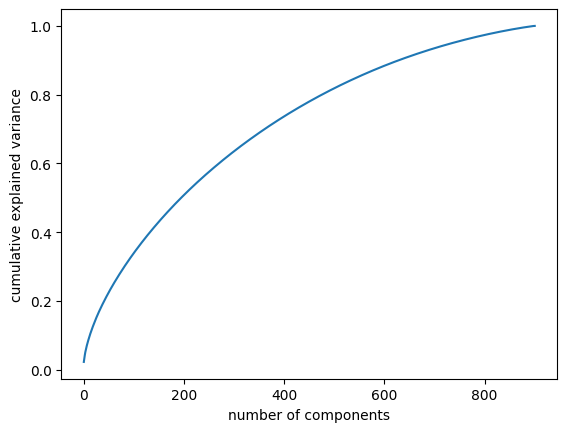

In [36]:
# PCA on tfidf b/c too many variables
tfidf_pca = PCA()
tfidf_pca.fit(train_dat_text_tfidf)
train_dat_text_pca = tfidf_pca.transform(train_dat_text_tfidf)

# https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
# cumulative scree plot
plt.plot(np.cumsum(tfidf_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [43]:
# take ~ 400 components
train_dat_text_fin = train_dat_text_pca[:, :400]
test_dat_text_fin = tfidf_pca.transform(test_dat_text_tfidf)[:, :400]

In [44]:
# combining data together
train_x = np.hstack([train_dat_clin_imp, train_dat_text_fin])
# val_x = np.hstack([val_dat_clin_imp, val_dat_text_tfidf])
test_x = np.hstack([test_dat_clin_imp, test_dat_text_fin])

train_y = train_dat_outcome.to_numpy()
# val_y = val_dat_outcome.to_numpy()
test_y = test_dat_outcome.to_numpy()

# https://imbalanced-learn.org/stable/combine.html
print("train/val/test shape: ", train_x.shape, test_x.shape)#, val_x.shape, test_x.shape)

train/val/test shape:  (901, 448) (159, 448)


In [45]:
# SMOTE for imbalance
smote = SMOTETomek(random_state = random_state)
train_x_resamp, train_y_resamp = smote.fit_resample(train_x, train_y)
print(train_x[train_y == 0].shape, train_x[train_y == 1].shape)
print(train_x_resamp[train_y_resamp == 0].shape, train_x_resamp[train_y_resamp == 1].shape)

(783, 448) (118, 448)
(783, 448) (783, 448)


## **Modelling**

In [46]:
params = {
    'LogisticRegressionCV' : {
        'penalty' : ['l2']
    },
    'SVC' : {
        'kernel' : ['linear', 'poly', 'rbf'],
        'degree' : [3, 4, 5]
    },
    'GaussianProcessClassifier' : { # https://stackoverflow.com/questions/62755556/gaussian-process-regression-hyparameter-optimisation-using-python-grid-search
            "kernel": [RBF(l) for l in np.logspace(-1, 1, 20)]
        },
    'XGBClassifier' : { # got from some towardsdatascience article i forgot
            'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
            'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
            'max_depth': [5,6,7,8,9,10,11,12,13,14],
            'n_estimators': [50,65,80,100,115,130,150],
            'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'eval_metric': ['auc'],
            'objective': ['binary:logistic']
    }
}

In [47]:
def fit(x, y, parameters, n_iter, random_state = 42):
    """
    Randomized hyperparameter tuning for fitting models

    parameters:
        n_iter -- number of parameter settings sampled
    """
    print("Training LogisticRegressionCV:")
    lr = LogisticRegressionCV(max_iter = int(1e6))
    rs_lr = RandomizedSearchCV(lr, parameters['LogisticRegressionCV'], n_iter = n_iter, random_state=random_state)
    rs_lr.fit(x, y) 

    print("Training SVC:")
    svc = SVC(probability = True)
    rs_svc = RandomizedSearchCV(svc, parameters['SVC'], n_iter = n_iter, random_state=random_state)
    rs_svc.fit(x, y)

    print("Training GaussianProcessClassifier:")
    gp = GaussianProcessClassifier()
    rs_gp = RandomizedSearchCV(gp, parameters['GaussianProcessClassifier'], n_iter = n_iter, random_state=random_state)
    rs_gp.fit(x, y)

    print("Training XGBClassifier:")
    xgb = XGBClassifier()
    rs_xgb = RandomizedSearchCV(xgb, parameters['XGBClassifier'], n_iter = n_iter, random_state=random_state)
    rs_xgb.fit(x, y) 

    models = [rs_lr, rs_svc, rs_gp, rs_xgb]
    return models 


In [48]:
models = fit(train_x_resamp, train_y_resamp, params, n_iter = 20, random_state = random_state)

Training LogisticRegressionCV:


/Users/rjunw/opt/anaconda3/envs/bst263_final/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training SVC:


/Users/rjunw/opt/anaconda3/envs/bst263_final/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training GaussianProcessClassifier:
Training XGBClassifier:


In [49]:
for model in models:
    print(model.best_estimator_, model.best_params_, model.best_score_)

LogisticRegressionCV(max_iter=1000000) {'penalty': 'l2'} 0.9329521173765288
SVC(probability=True) {'kernel': 'rbf', 'degree': 3} 0.9578539305264444
GaussianProcessClassifier(kernel=RBF(length_scale=0.1)) {'kernel': RBF(length_scale=0.1)} 0.8965527767037708
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.300000012,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=115, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_sta

In [50]:
def evaluate(x, y, models):
    scores = {
        'ACC': [], 
        'AUC': [],
        'CMAT': [],
        'CMAT_norm': []
    }
    for model in models:
        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:, 1]
        scores['ACC'].append(accuracy_score(y, y_pred))
        scores['AUC'].append(roc_auc_score(y, y_proba))
        scores['CMAT'].append(confusion_matrix(y, y_pred))
        scores['CMAT_norm'].append(confusion_matrix(y, y_pred, normalize='true'))
        
    return scores 

In [51]:
evaluate(test_x, test_y, models)

{'ACC': [0.8490566037735849,
  0.8427672955974843,
  0.8176100628930818,
  0.8427672955974843],
 'AUC': [0.7805383022774326,
  0.7346445824706693,
  0.7839889579020014,
  0.7601794340924777],
 'CMAT': [array([[127,  11],
         [ 13,   8]]),
  array([[128,  10],
         [ 15,   6]]),
  array([[118,  20],
         [  9,  12]]),
  array([[126,  12],
         [ 13,   8]])],
 'CMAT_norm': [array([[0.92028986, 0.07971014],
         [0.61904762, 0.38095238]]),
  array([[0.92753623, 0.07246377],
         [0.71428571, 0.28571429]]),
  array([[0.85507246, 0.14492754],
         [0.42857143, 0.57142857]]),
  array([[0.91304348, 0.08695652],
         [0.61904762, 0.38095238]])]}

## **Feature Importance**

In [54]:
feature_names = list(clin_col) + ['PC' + str(i) for i in range(1, 401)]
features = np.array(feature_names) 
print(len(features))

448


Permutation feature importance fits a baseline metric, permutes feature columns and evaluates metric again. Permutation importance is difference between baseline and feature permutation.

Text(0.5, 0, 'RBF LR Permutation Importance')

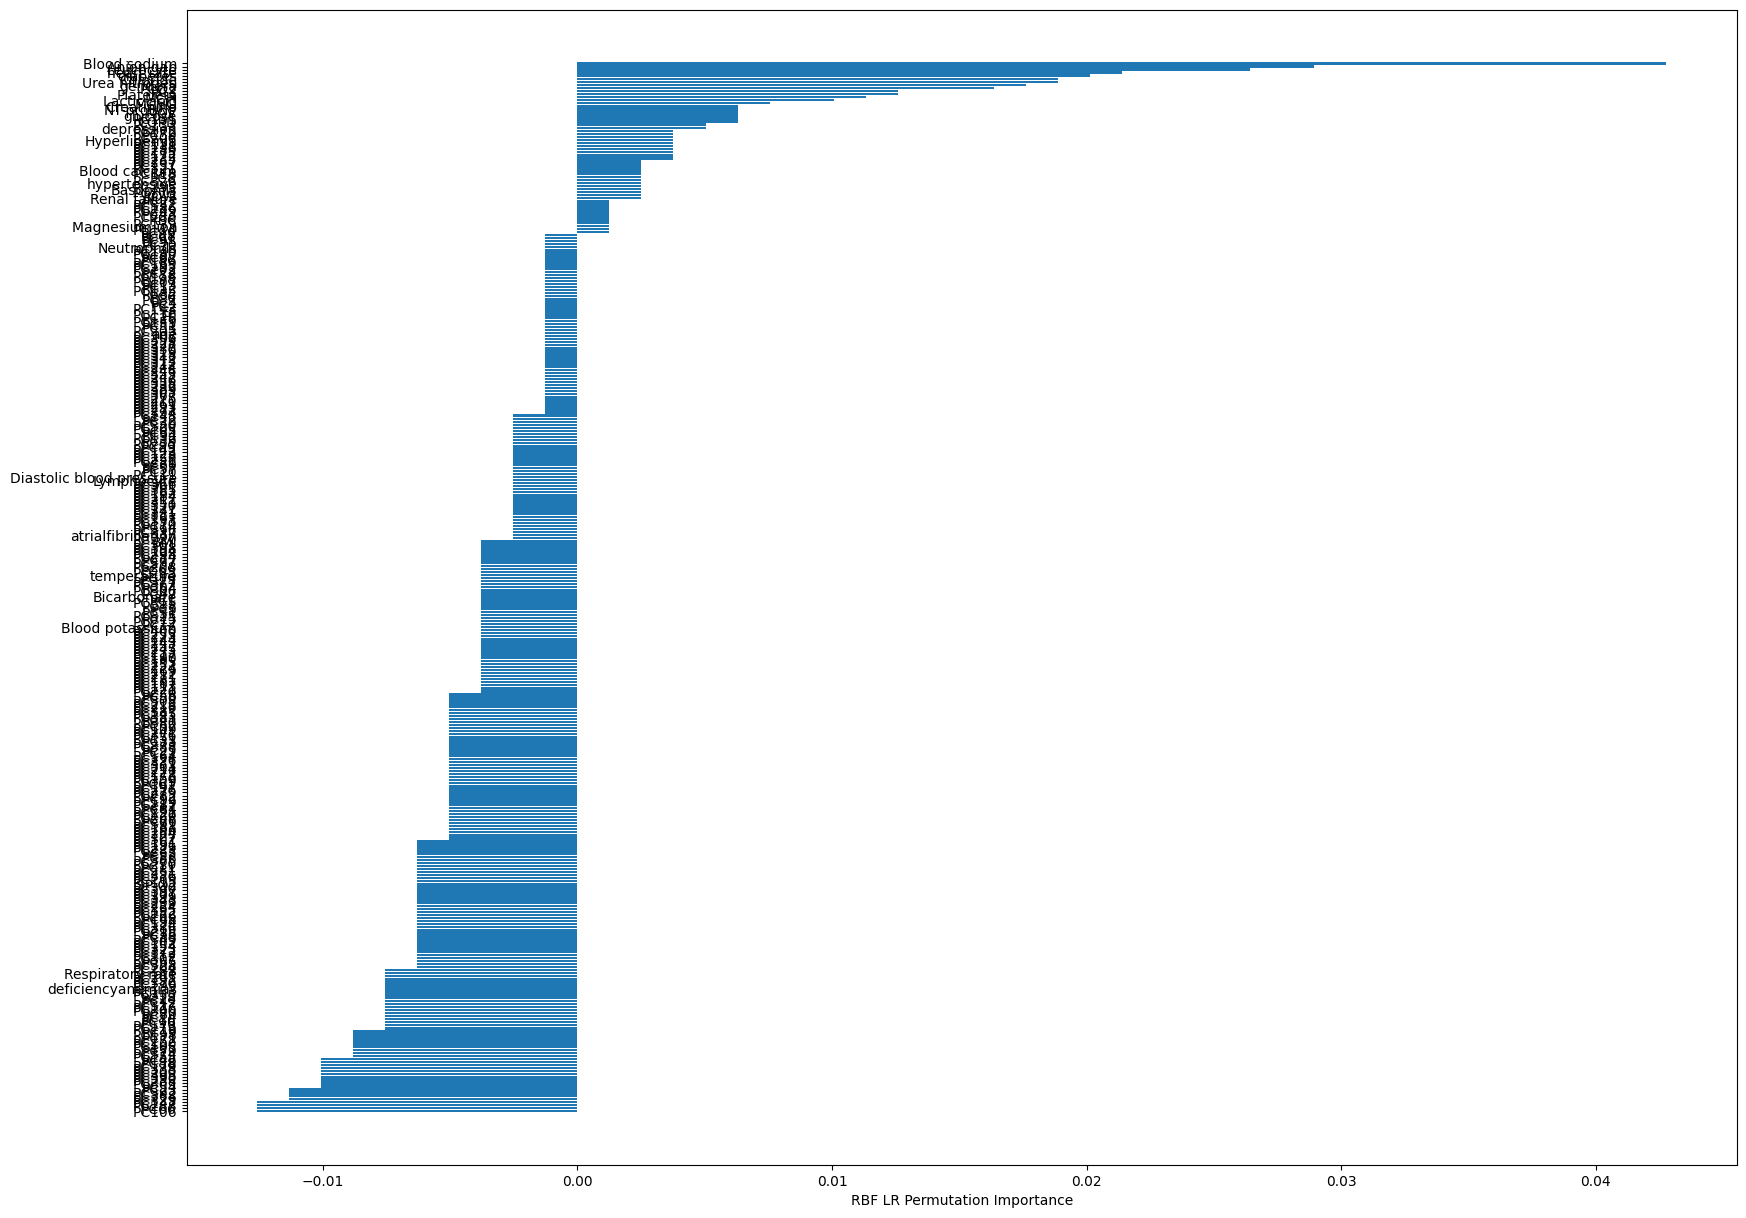

In [65]:
# RBF LR importance
perm_importance_lr = permutation_importance(models[0].best_estimator_, test_x, test_y)
sorted_idx = perm_importance_lr.importances_mean.argsort() # also remove 0s
sorted_idx = sorted_idx[perm_importance_lr.importances_mean[sorted_idx] != 0]
plt.figure(figsize = (20, 15))
plt.barh(features[sorted_idx], perm_importance_lr.importances_mean[sorted_idx])
plt.xlabel("RBF LR Permutation Importance")

Text(0.5, 0, 'RBF SVC Permutation Importance')

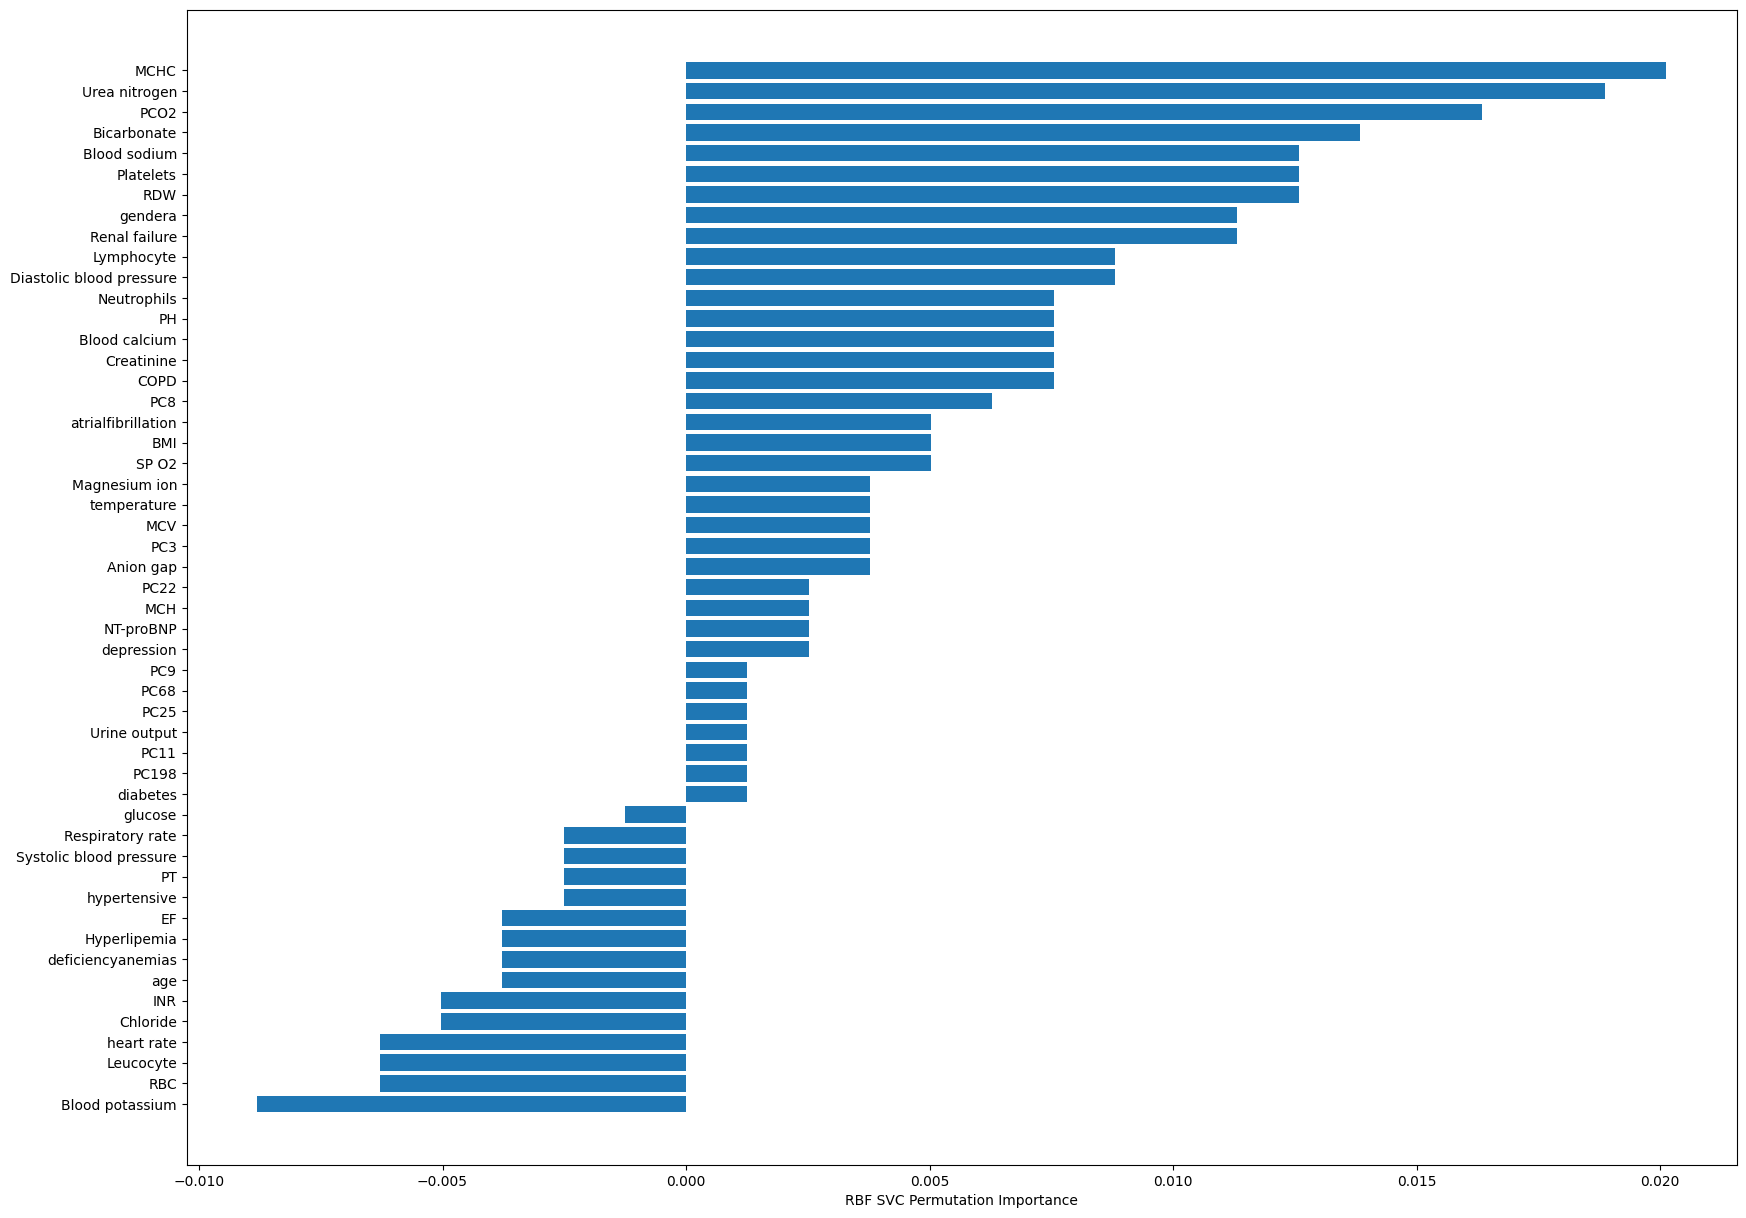

In [62]:
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
# RBF SVC importance
perm_importance_svc = permutation_importance(models[1].best_estimator_, test_x, test_y)
sorted_idx = perm_importance_svc.importances_mean.argsort() # also remove 0s
sorted_idx = sorted_idx[perm_importance_svc.importances_mean[sorted_idx] != 0]
plt.figure(figsize = (20, 15))
plt.barh(features[sorted_idx], perm_importance_svc.importances_mean[sorted_idx])
plt.xlabel("RBF SVC Permutation Importance")

Text(0.5, 0, 'RBF GP Permutation Importance')

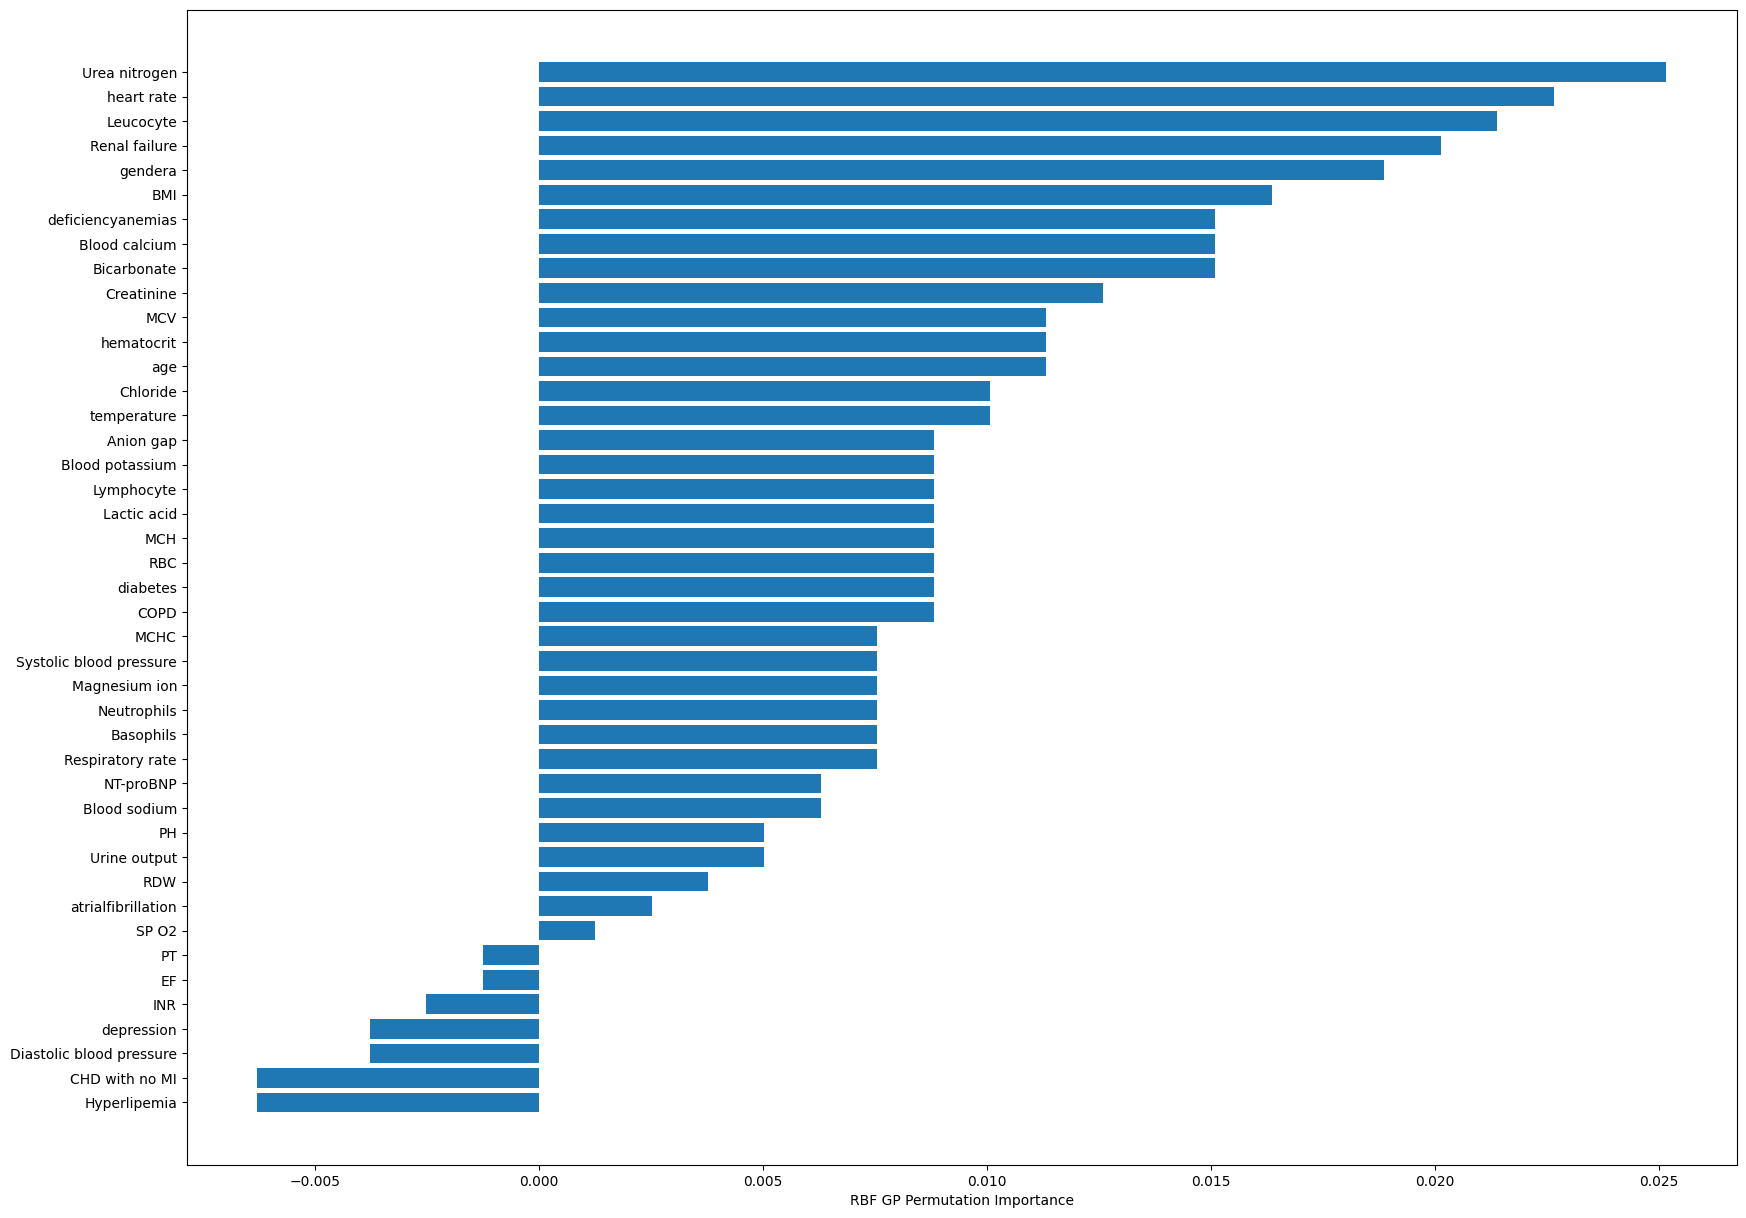

In [64]:
# RBF GP importance
perm_importance_gp = permutation_importance(models[2].best_estimator_, test_x, test_y)
sorted_idx = perm_importance_gp.importances_mean.argsort()
sorted_idx = sorted_idx[perm_importance_gp.importances_mean[sorted_idx] != 0]
plt.figure(figsize = (20, 15))
plt.barh(features[sorted_idx], perm_importance_gp.importances_mean[sorted_idx])
plt.xlabel("RBF GP Permutation Importance")

Text(0.5, 0, 'RBF XGB Permutation Importance')

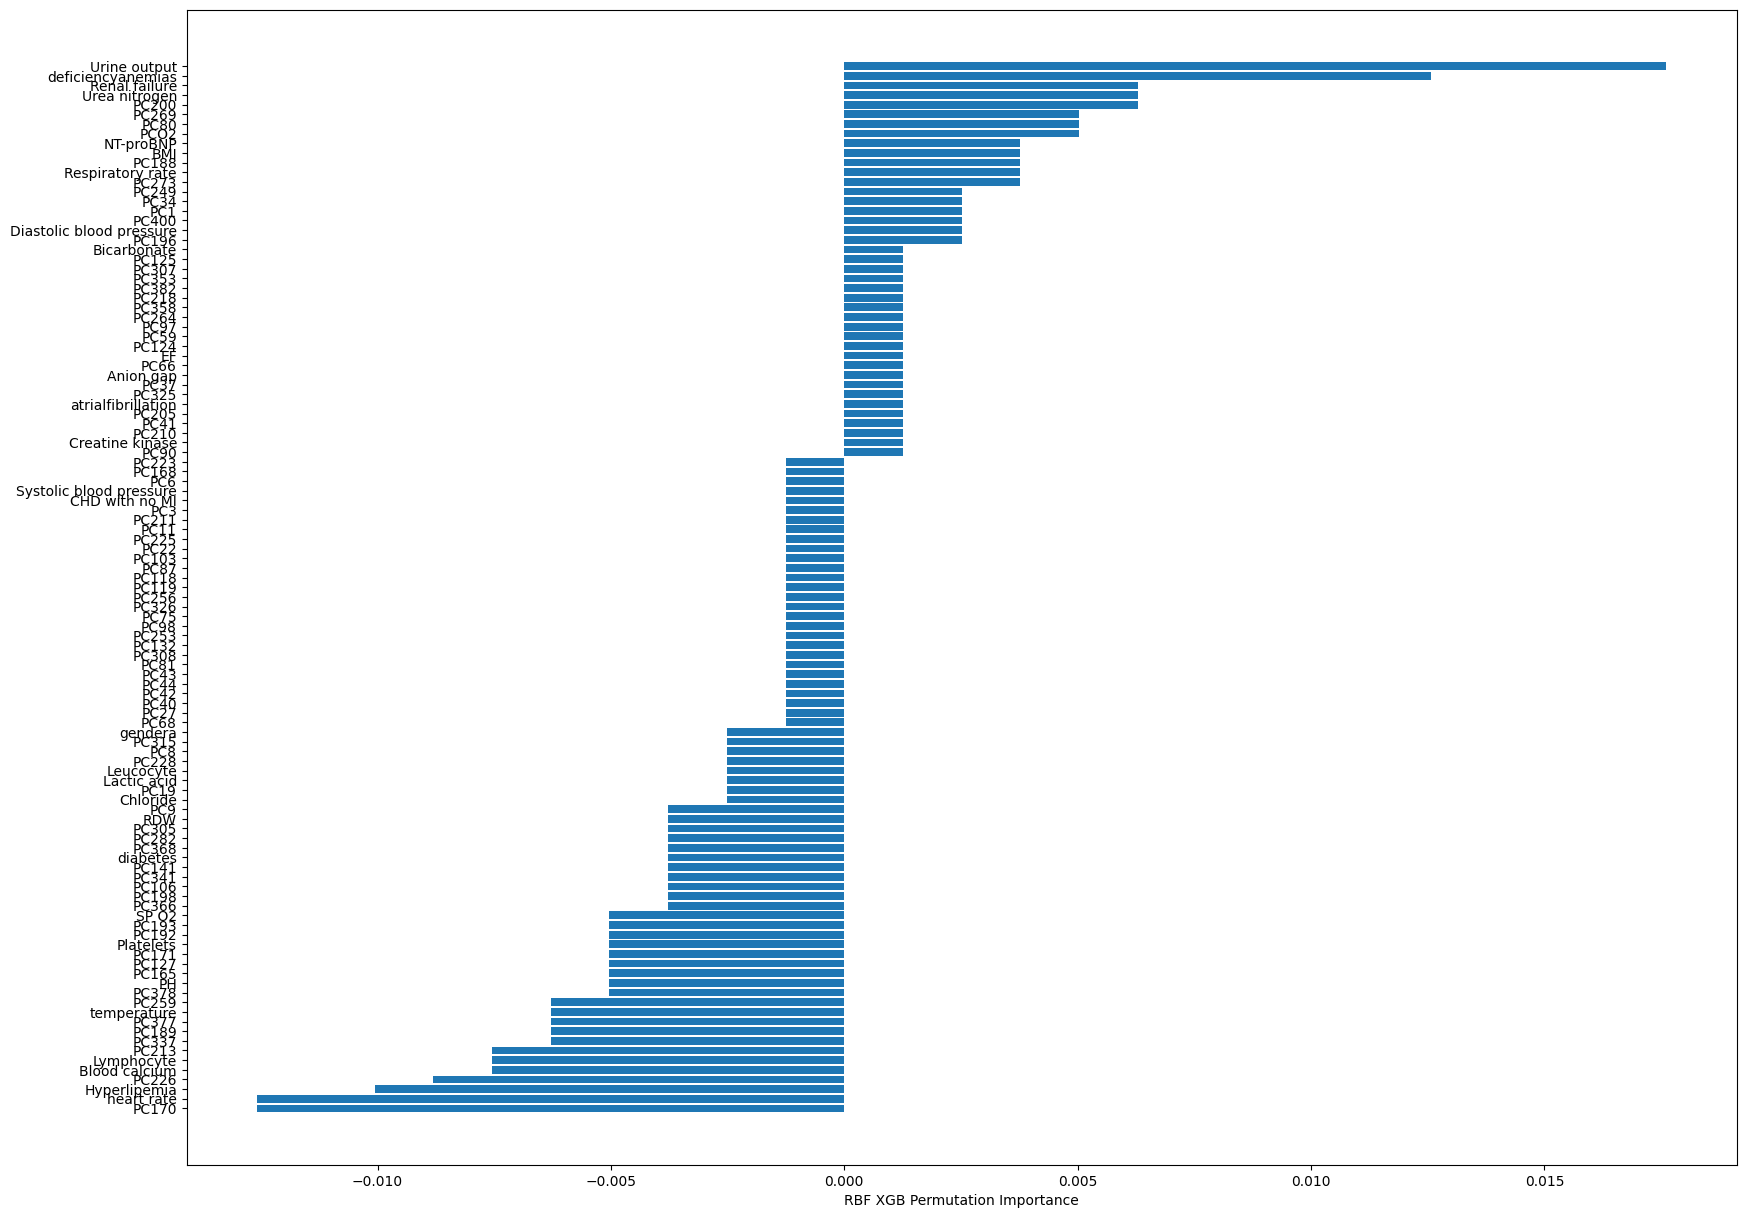

In [66]:
# RBF SVC importance
perm_importance_xgb = permutation_importance(models[3].best_estimator_, test_x, test_y)
sorted_idx = perm_importance_xgb.importances_mean.argsort() # also remove 0s
sorted_idx = sorted_idx[perm_importance_xgb.importances_mean[sorted_idx] != 0]
plt.figure(figsize = (20, 15))
plt.barh(features[sorted_idx], perm_importance_xgb.importances_mean[sorted_idx])
plt.xlabel("RBF XGB Permutation Importance")

## **Viz**